***
# Base Bi-LSTM Model using only 17k training and 5k of val of the original data of 90% training<br>
***

***
## 1 Load the train/val/test/balanced test datasets
emotions_with_neutrals_220228.csv concatenated the neutrals from Kaggle dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion<br>

In [1]:
import pandas as pd
import numpy as np

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

train_source = project_folder + '/datasets/train_data_imbalanced_stratified_no_dupe_17k_5k.csv'
test_source = project_folder + '/datasets/test_data_imbalanced_stratified_no_dupe.csv'
val_source = project_folder + '/datasets/validation_data_imbalanced_stratified_no_dupe_5k_17k.csv'
balanced_test_source = project_folder + '/datasets/test_data_balanced_no_dupe.csv'

# Load the dfs
train_df = pd.read_csv(train_source)
test_df = pd.read_csv(test_source)
val_df = pd.read_csv(val_source)
balanced_test_df = pd.read_csv(balanced_test_source)

# drop the tweet_id column
train_df.drop(columns=train_df.columns[0], axis=1, inplace=True)
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)
val_df.drop(columns=val_df.columns[0], axis=1, inplace=True)
balanced_test_df.drop(columns=balanced_test_df.columns[0], axis=1, inplace=True)

### Confirm no overlapping records 

In [3]:
# Check if there are any records in train_df that are in val_df
overlap = train_df['text'].isin(val_df['text'])
print(f"Number of overlapping records, train-val: {overlap.sum()}")

# Check if there are any records in val_df that are in train_df
overlap = val_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, val-train: {overlap.sum()}")


# Check if there are any records in train_df that are in test_df
overlap = train_df['text'].isin(test_df['text'])
print(f"Number of overlapping records, train-test: {overlap.sum()}")

# Check if there are any records in test_df that are in train_df
overlap = test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, test-train: {overlap.sum()}")


# Check if there are any records in train_df that are in balanced_test_df
overlap = train_df['text'].isin(balanced_test_df['text'])
print(f"Number of overlapping records, train-balanced test: {overlap.sum()}")

# Check if there are any records in train_df that are in balanced_test_df
overlap = balanced_test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, balanced test, train: {overlap.sum()}")

Number of overlapping records, train-val: 0
Number of overlapping records, val-train: 0
Number of overlapping records, train-test: 0
Number of overlapping records, test-train: 0
Number of overlapping records, train-balanced test: 0
Number of overlapping records, balanced test, train: 0


In [4]:
train_df

,text,emotions
0,i feel so repressed with this one now,sadness
1,im feeling very thankful this evening for many...,joy
2,i would not feel so dismayed everybody must ge...,sadness
3,i feel like i m rich in that department,joy
4,ill sink again a time or two before i can real...,joy
...,...,...
17077,i to feel angry and pissed when everything is ...,anger
17078,@oyfreakinvey rofl,neutral
17079,ive thought about killing myself so i wouldnt ...,sadness
17080,i feel eager to get started,joy


In [5]:
val_df

,text,emotions
0,i can feel that tomorrow i will remember this ...,joy
1,i can feel is grief for the innocent lives bli...,joy
2,i deprive all those who might have even an ink...,love
3,i remember reading it feeling terrified at the...,fear
4,i guess its her way of feeling like shes popul...,joy
...,...,...
5120,i went away feeling tremendously reassured,joy
5121,i feel completely listless about the holidays ...,sadness
5122,i feel more self assured and confident in my a...,joy
5123,i feel about talbots i dont care for their clo...,love


In [6]:
test_df

,text,emotions
0,i feel impatient to get moving forward,anger
1,i have decided to open wb to a few thoughtful ...,joy
2,i resolved at that moment to do my bit when i ...,sadness
3,i like his tip especially if you need assistan...,joy
4,i feel that if he did not want to be on the sh...,joy
...,...,...
37956,i am serving alongside other leaders in the de...,fear
37957,i am a little tipsy and feeling quite fond of ...,love
37958,i made my way to the front of the stage feelin...,fear
37959,i feel like nicholas is a really smart guy and...,joy


In [7]:
balanced_test_df

,text,emotions
0,i will get at the heart of the matter that you...,anger
1,i still feel selfish about it at times,anger
2,i feel a sarcastic emptyness and void in my life,anger
3,overeating a traditional type of food blood pu...,anger
4,i just have this feeling that im going to be b...,anger
...,...,...
6015,i am giving myself permission to feel funny aga,surprise
6016,i feel shocked angry confused,surprise
6017,im writing this blog post and feeling totally ...,surprise
6018,i feel this for all my grandchildren and with ...,surprise


***
## 2 Tokenizer

### Find the top word count (frequency > 10)
We'll use this number as our vocabulary size

In [8]:
# Split the text column into a list of words
words_df = train_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

,words,count
0,!,2
1,!!,1
2,!!my,1
3,#cycling,1
4,#fb,2
...,...,...
17247,zyl,1
17248,|,1
17249,~,1
17250,ï¿½WHYYY????????,1


In [9]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)
new_words_df

,words,count
7761,i,26872
6013,feel,11453
1256,and,9986
15479,to,9426
15264,the,8784
...,...,...
3323,clients,11
13123,rush,11
8149,instantly,11
8093,inner,11


In [10]:
# how many words are > 10?
top_word_count = len(new_words_df)
print('Vocabulary size:', top_word_count)

Vocabulary size: 2056


### Let's tokenize the train tweets!

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text']) # pass in tweets from training set

In [13]:
# this is what the tweet looks like as words
train_df['text'][0]

'i feel so repressed with this one now'

In [14]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([train_df['text'][0]])

[[2, 3, 18, 1479, 24, 25, 66, 57]]

(array([2.000e+01, 5.200e+01, 3.150e+02, 5.290e+02, 5.850e+02, 6.630e+02,
        6.860e+02, 6.890e+02, 6.670e+02, 6.710e+02, 7.120e+02, 1.311e+03,
        6.880e+02, 6.780e+02, 6.480e+02, 6.260e+02, 6.030e+02, 5.450e+02,
        5.290e+02, 4.620e+02, 4.560e+02, 4.320e+02, 7.680e+02, 3.060e+02,
        3.230e+02, 2.940e+02, 2.580e+02, 2.400e+02, 2.290e+02, 2.260e+02,
        1.820e+02, 1.770e+02, 1.690e+02, 2.620e+02, 1.150e+02, 1.100e+02,
        1.040e+02, 8.800e+01, 7.100e+01, 6.900e+01, 6.700e+01, 5.400e+01,
        6.200e+01, 4.900e+01, 7.400e+01, 3.700e+01, 2.400e+01, 3.600e+01,
        2.700e+01, 2.000e+01, 2.000e+01, 1.800e+01, 1.500e+01, 4.000e+00,
        5.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([ 1.        ,  2.08955224,  3.17910448,  4.26865672,  5.35820896,
         6.44776119,  7.53731343,  8.62686567,  9.71641791, 10.80597015,
        11.89552239

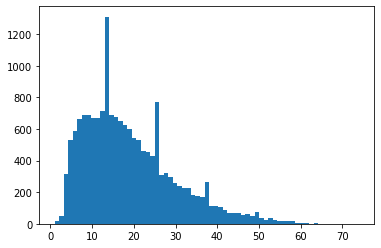

In [15]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in train_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [16]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(train_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word count:', max(word_count_list))
print('Minimum word count:', min(word_count_list))
print('Mean word count:', statistics.mean(word_count_list))
print('Median word count:', statistics.median(word_count_list))
print('75th percentile word count:', np.percentile(word_count_list, 75))
print('85th percentile word count:', np.percentile(word_count_list, 85))
print('95th percentile word count:', np.percentile(word_count_list, 95))

Maximum word count: 74
Minimum word count: 1
Mean word count: 19.034656363423487
Median word count: 17.0
75th percentile word count: 25.0
85th percentile word count: 31.0
95th percentile word count: 41.0


The max number of words is 101. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

***
## 3 Padding and truncating the training data sequences to make sure that the shape is the same for each string.

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
max_len = 200 # set the largest tweet size, >200 words -> truncate, <200 words -> pad

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [19]:
padded_train_seq = get_sequences(tokenizer, train_df['text'])
padded_train_seq[0]

array([   2,    3,   18, 1479,   24,   25,   66,   57,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

***
## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for all datasets)

In [20]:
# def convert_labels_to_numeric(data):
#   classes = set(data)

#   # convert class to index
#   c_to_i = dict((c, i) for i, c in enumerate(classes))
#   i_to_c = dict((v, k) for k, v in c_to_i.items())
  
#   return c_to_i

In [21]:
class_to_index_dict = {'sadness': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5, 'neutral': 6}
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [22]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [23]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
train_labels = names_to_ids(class_to_index_dict, train_df['emotions'])
print('train_df.iloc[7]:\n', train_df.iloc[index])
print('numeric label:', train_labels[index])

train_df.iloc[7]:
 text        i didnt expect to feel so cool when i thought ...
emotions                                                  joy
Name: 7, dtype: object
numeric label: 4


***
## 5 Create the model

In [24]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [25]:
# ref: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
# ref: https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# ref: https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

# keep the vocabulary size the same as the base model, 11039
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=11039, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the seven classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 8)            88312     
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1520      
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 147       
                                                                 
Total params: 89,979
Trainable params: 89,979
Non-trainable params: 0
_________________________________________________________________


***
## 6 Train the model

### Convert the labels of the validation set to numeric (just like the training set)

In [27]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [28]:
val_seq = get_sequences(tokenizer, val_df['text'])
val_labels = names_to_ids(class_to_index_dict, val_df['emotions'])

In [29]:
# checking out the first input in validation sequence
val_seq[0], val_df['text'][0], val_df['emotions'][0]

(array([   2,   41,    3,   10,  715,    2,   54,  195,   25, 1707,  136,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [30]:
print('val_df.iloc[0]:\n', val_df.iloc[0])
print('numeric label:', val_labels[0])

val_df.iloc[0]:
 text        i can feel that tomorrow i will remember this ...
emotions                                                  joy
Name: 0, dtype: object
numeric label: 4


#### Check out the shape to make sure they're as expected

In [31]:
padded_train_seq.shape

(17082, 200)

In [32]:
train_labels.shape

(17082,)

In [33]:
val_seq.shape

(5125, 200)

In [34]:
val_labels.shape

(5125,)

### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch
If generator is not used, might delete this section

In [35]:
# from sklearn.utils.random import sample_without_replacement

# # Define a generator function
# def generator(data, labels, batch_size):
#     # num_samples = len(data)
#     # while True:
#     #     indices = np.random.randint(num_samples, size=batch_size)
#     #     yield data[indices], labels[indices]

#     # Loop over batches
#     for i in range(0, len(data), batch_size):
      
#       # Get a batch of indices using sample_without_replacement()
#       batch_indices = sample_without_replacement(n_population=len(data), n_samples=batch_size)
      
#       # Yield a batch of features and labels using the indices
#       yield data[batch_indices], labels[batch_indices]

In [36]:
# Create the generator
# batch_size = 1 # using this batch size because that's what seemed reasonable based on the number of records in the training dataset
# gen = generator(data=padded_train_seq, labels=train_labels, batch_size=batch_size)

#### Setting up checkpoints

In [37]:
# reference: https://pynative.com/python-timezone/
# make a timestamp so it can be part of the folder name
# otherwise, all the checkpoints get dumped into the same
# folder and that's not great
import datetime
import pytz

local_tz = pytz.timezone('America/Denver')
local_dt = datetime.datetime.now(local_tz)

# Format the datetime object as a string without spaces
timestamp = local_dt.strftime('/%Y-%m-%d-%H%M')

# Print the string
print(timestamp)

/2023-03-09-2126


In [38]:
!ls '/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/'

17_5_model  archive  base_model


In [39]:
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints/17_5_model'
checkpoint_filepath = checkpoint_dir + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5' #+ timestamp + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [40]:
# check to make sure that the folder name is as expected
# format: .....cm_checkpoints/YYYY-MM-DD-TIME/....
print(checkpoint_filepath)

/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/17_5_model/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5


### Training the Model!!!

##### Uncomment cell below to load checkpoints; else keep commented to start fresh

In [41]:
# uncomment below when loading checkpoints
# hdf5_checkpoint = 'weights.05-0.99' # change this to the right filename for the checkpoint
# checkpoint_filepath = checkpoint_dir + '/' + hdf5_checkpoint + '.hdf5'
# model.load_weights(checkpoint_filepath)

In [42]:
# batch_size = 64
# steps_per_epoch = len(padded_train_seq) / batch_size

# history = model.fit(
#     gen,
#     validation_data=(val_seq, val_labels),
#     steps_per_epoch=steps_per_epoch,
#     epochs=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
#         model_checkpoint_callback
#     ]
# )

##### Training a fresh model (don't run this if running cells above)

In [43]:
batch_size = 64
steps_per_epoch = len(padded_train_seq) / batch_size

history = model.fit(
    # gen,
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
        model_checkpoint_callback
    ]
)

Epoch 1/5
266/266 [==============================] - 33s 86ms/step - loss: 1.6099 - accuracy: 0.3510 - val_loss: 1.4923 - val_accuracy: 0.4137
Epoch 2/5
266/266 [==============================] - 6s 24ms/step - loss: 1.3006 - accuracy: 0.4876 - val_loss: 1.2181 - val_accuracy: 0.5536
Epoch 3/5
266/266 [==============================] - 7s 25ms/step - loss: 0.9914 - accuracy: 0.6657 - val_loss: 0.8837 - val_accuracy: 0.6966
Epoch 4/5
266/266 [==============================] - 6s 24ms/step - loss: 0.7700 - accuracy: 0.7311 - val_loss: 0.7533 - val_accuracy: 0.7286
Epoch 5/5
266/266 [==============================] - 5s 20ms/step - loss: 0.6613 - accuracy: 0.7475 - val_loss: 0.7082 - val_accuracy: 0.7331


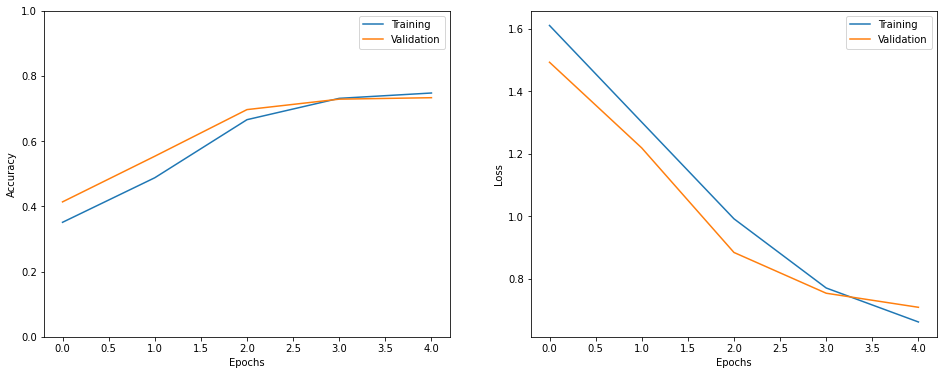

In [44]:
show_history(history)

***
## 7 Evaluate the model using imbalanced test_df

In [45]:
# borrowing this from A3 assignment, but turned it into a function
# classification report (cr) and confusion matrix (cm) from A3
from sklearn.metrics import classification_report
import seaborn as sns

def make_cr_cm(preds, labels):

  predictions_model = tf.argmax(preds, axis=-1)
  predictions_model

  # convert labels to string because classification_report needs target_names as str
  # labels are currently ints, but will change to str of in (i.e. '0', '1', etc)
  class_names = list(set([str(digit) for digit in labels]))

  # convert digits in target_names to the actual name of the emotion from the 
  # using class_to_index dictionary (i.e. '0' -> 'love', '5' -> 'neutral', etc.)
  class_names = [list(class_to_index_dict.keys())[list(class_to_index_dict.values()).index(int(name))] for name in class_names]

  print('Classification Report:\n\n', classification_report(labels, predictions_model.numpy(), target_names=class_names))

  print('Confusion Matrix:\n')
  
  # confusion matrix from A3
  cm = tf.math.confusion_matrix(labels, predictions_model)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,7))
  sns.heatmap(
      cm, annot=True,
      xticklabels=class_names,
      yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

### Padding the imbalanced test set for evaluation

In [46]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([  2,   3, 530,   5,  56, 838, 793,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [47]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [48]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_dict, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 text        i never orgasm the feeling is lovely
emotions                                    love
Name: 7, dtype: object
numeric label: 5


### Evaluating the model using test_df!!!

In [49]:
model.evaluate(padded_test_seq, test_labels)

1187/1187 [==============================] - 13s 11ms/step - loss: 0.7056 - accuracy: 0.7344


[0.7055549621582031, 0.7343589663505554]

In [50]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i took some photos of the chapel and the views...
emotions                                                 fear
Name: 10156, dtype: object
Emotion: 2
1/1 [==============================] - 1s 1s/step
Predicted Emotion: 1


In [51]:
preds_imbalanced_test_set = model.predict(padded_test_seq)

1187/1187 [==============================] - 7s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

               precision    recall  f1-score   support

         joy       0.90      0.95      0.93     11587
    surprise       0.37      0.93      0.53      5226
        love       0.00      0.00      0.00      3955
        fear       0.00      0.00      0.00       982
     neutral       0.96      0.93      0.94     12917
     sadness       0.00      0.00      0.00      2434
       anger       1.00      0.03      0.06       860

    accuracy                           0.73     37961
   macro avg       0.46      0.40      0.35     37961
weighted avg       0.67      0.73      0.68     37961

Confusion Matrix:



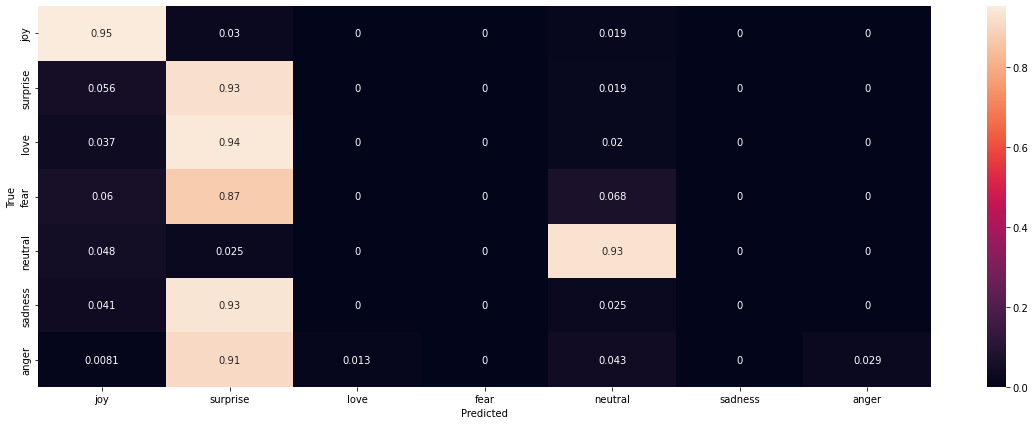

In [52]:
make_cr_cm(preds_imbalanced_test_set, test_labels)

***
## 8 Evaluating the model again, but with balanced_test_df!!!

### Padding the balanced test set for evaluation

In [53]:
padded_balanced_test_seq = get_sequences(tokenizer, balanced_test_df['text'])
padded_balanced_test_seq[0]

array([   2,   54,   56,   34,    6,  241,    9,    6,  548,   10,   30,
        108,   30,   62,   24,    4,    3,   60,    6,  241,   10, 1104,
         30,   36,  137,  726,    6, 1613,    9,  114,    1,    9,  110,
         30,  835, 1634,   20,    7,  971,  881,    1,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [54]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [55]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
balanced_test_labels = names_to_ids(class_to_index_dict, balanced_test_df['emotions'])
print('balanced_test_df.iloc[7]:\n', balanced_test_df.iloc[index])
print('numeric label:', balanced_test_labels[index])

balanced_test_df.iloc[7]:
 text        i feel like i m wronged
emotions                      anger
Name: 7, dtype: object
numeric label: 1


### Evaluating the model using balanced_test_df!!!

In [56]:
model.evaluate(padded_balanced_test_seq, balanced_test_labels)

189/189 [==============================] - 2s 9ms/step - loss: 1.3969 - accuracy: 0.4047


[1.3968619108200073, 0.4046511650085449]

In [57]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(balanced_test_labels) - 1)

print('Sentence:', balanced_test_df.iloc[i])
print('Emotion:', balanced_test_labels[i])

p = model.predict(np.expand_dims(padded_balanced_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i feel so empty when you are not beside me
emotions                                       sadness
Name: 4482, dtype: object
Emotion: 0
1/1 [==============================] - 0s 36ms/step
Predicted Emotion: 0


In [58]:
preds_balanced_test_set = model.predict(padded_balanced_test_seq)

189/189 [==============================] - 1s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

               precision    recall  f1-score   support

         joy       0.79      0.95      0.86       860
    surprise       0.20      0.94      0.33       860
        love       0.00      0.00      0.00       860
        fear       0.00      0.00      0.00       860
     neutral       0.83      0.92      0.87       860
     sadness       0.00      0.00      0.00       860
       anger       1.00      0.03      0.06       860

    accuracy                           0.40      6020
   macro avg       0.40      0.40      0.30      6020
weighted avg       0.40      0.40      0.30      6020

Confusion Matrix:



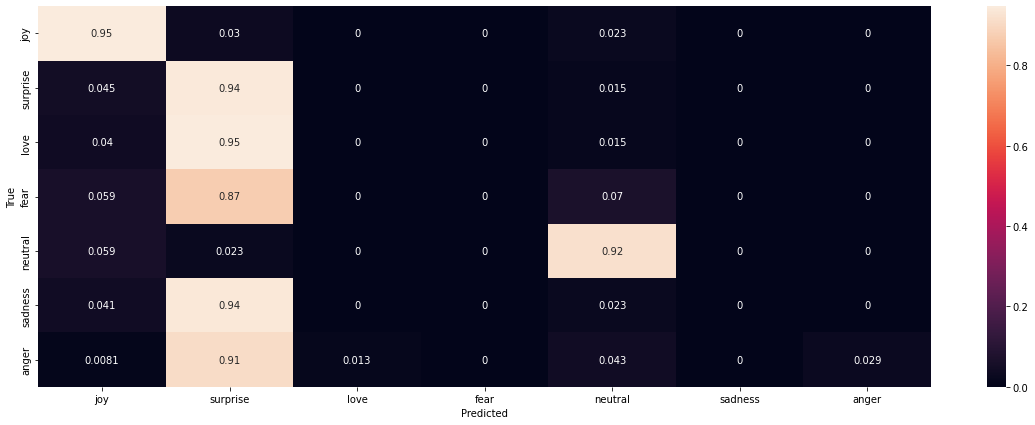

In [60]:
make_cr_cm(preds_balanced_test_set, balanced_test_labels)